In [1]:
using Distributed
if(length(procs())<4)
    addprocs()
end
using Plots
@everywhere using DifferentialEquations, ParameterizedFunctions
@everywhere using SharedArrays

#### 说明
    分布式版本，其实最好的是另外写到一个文件里面，然后用`@everywhere`去include

### 1. air situation
状态：u = [x, y, z, vx, vy, vz]

参数：p = [g, l0, α, β]

In [2]:
@everywhere function calc_foot_end(u, p)
    """ calculate the foot position in air """
    x, y, z = u[1:3]
    l0, α, β = p[2:4]
    x_pf = x + l0*cos(β)sin(α)
    y_pf = y + l0*sin(β)
    z_pf = z - l0*cos(β)cos(α)
    return (x_pf, y_pf, z_pf)
end

In [3]:
@everywhere function diff_fun_fly!(du, u, p, t)
    """ Differential Equations in air"""
    x, y, z, vx, vy, vz = u
    g = p[1]
    du[1], du[2], du[3] = dx, dy, dz = vx, vy, vz
    du[4], du[5], du[6] = 0.0, 0.0, -g 
end

@everywhere cond_contact(u, t, integrator) = calc_foot_end(u, integrator.p)[3]  # positive-->negative
@everywhere affect_contact!(integrator) = terminate!(integrator)
@everywhere cond_peak(u, t, integrator) = u[6]

### 2. ground situation

参数：p2 = [m, g, l0, k1, k2, x0, y0, z0]

In [4]:
# controller
@everywhere function compressingCalc(u, p)
    """ decide if on compressing """
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2
end
@everywhere function k1k2Force(u, p)
    """ Control law1: using fixed k1, k2 model """
    k1, k2, x0, y0, z0 = p[4:8]
    l0 = p[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    k = compressingCalc(u, p)<=0 ? k1 : k2

    fx = - k * (x - (x0 - l0*(x0-x)/l))
    fy = - k * (y - (y0 - l0*(y0-y)/l))
    fz = - k * (z - ( 0 - l0*(z0-z)/l))
    return (fx, fy, fz)
end
@everywhere function jointForce(u, p)
    """Calculation: k force --> joint force"""
    p1, p2 = p[1], p[2]
    k1, k2, x0, y0, z0 = p2[4:8]
    l0 = p2[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    k = compressingCalc(u, p2)<=0 ? k1 : k2
    kforce = k*abs(l0-l)
    tmp = l0^2 - l^2
    if tmp < 0
        if tmp > -0.003
            tmp = 0.0
        else
            # 其实在遇到这个问题的时候我不希望仿真结束，而想要记录下这个问题然后继续
            println("error in mass point position:", tmp, ", with", [p1[3], p1[4],k1, k2])
            tmp = 0.0
        end
    end
    torque = kforce * sqrt(tmp)/2
    return torque
end

In [5]:
@everywhere function diff_fun_support!(du, u, p, t)
    """ Differential Equations on ground """
    m, g = p[1:2]
    x, y, z, vx, vy, vz = u
    
    fx, fy, fz = k1k2Force(u, p)          # force specification
    ax, ay, az = fx/m, fy/m, (fz-m*g)/m
    du[1], du[2], du[3] = vx, vy, vz
    du[4], du[5], du[6] = ax, ay, az
end

@everywhere function cond_compressed(u, t, integrator)
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = integrator.p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2                   # negative-->positive
end

@everywhere function cond_leave(u, t, integrator)
    """ Condition: Leave ground """
    x, y, z = u[1:3]
    x0, y0, z0 = integrator.p[6:8]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-z0)^2)
    return (l - integrator.p[3])
end

### 3. 综合
初始条件：s0 = [z0, vx0, vy0]

控制器条件：ctrl = [[α, β, k1, k2]]

返回值：有效轨迹，足地接触点

In [6]:
@everywhere function cycleCalc(m, l0, s0, ctrl)
    α, β, k1, k2 = ctrl
    z0, vx0, vy0 = s0
    u0 = [0.0, 0.0, z0, vx0, vy0, 0.0]
    tspan = (0.0, 4.0)
    p1 = (9.8, l0, α, β, k1, k2)
    # ------------------------------------------------------
    # segment1, air-->contact
    # the initial foot positon is not supposed to be underground!
    # ------------------------------------------------------
    if(calc_foot_end(u0, p1)[3] <= 0)           # check
        return ([], [], [p1,])
    end
    
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p1)
    cb = ContinuousCallback(cond_contact, affect_contact!)
    sol1 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    # ------------------------------------------------------
    # segment2, compressing
    # if segment1 end with opposite velocity, simulation may get wired!
    # ------------------------------------------------------
    u0 = sol1.u[end]    
    foot_p = calc_foot_end(u0, p1)
    p2 = [m, 9.8, l0, k1, k2, foot_p...]
    if(compressingCalc(u0, p2) > 0)
        return ([sol1,], foot_p, [p1, p2])               # check
    end
    
    prob = ODEProblem(diff_fun_support!, u0, tspan, p2)
    cb = ContinuousCallback(cond_compressed, terminate!)
    sol2 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)

    # -----------------------------------------------------
    # segment3, thrusting
    # compressing should not be too much! small k
    # -----------------------------------------------------
    u0, p3 = sol2.u[end], p2
    if(u0[3] <= 0)
        return ([sol1, sol2,], foot_p, [p1, p2, p3,])
    end
    prob = ODEProblem(diff_fun_support!, u0, tspan, p3)
    cb = ContinuousCallback(cond_leave, terminate!, abstol=1e-9)
    sol3 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    # -----------------------------------------------------
    # segment4, air up
    # thrusting initial z velocity shou be positive
    # -----------------------------------------------------
    u0, p4 = sol3.u[end], p1
    if(u0[6] <= 0)
        return ([sol1, sol2, sol3,], foot_p, [p1, p2, p3,p4])
    end
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p4)
    cb = ContinuousCallback(cond_peak, terminate!)
    sol4 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    return ([sol1, sol2, sol3, sol4], foot_p, [p1, p2, p3, p4])
end

┌ Info: Recompiling stale cache file /home/kuro/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


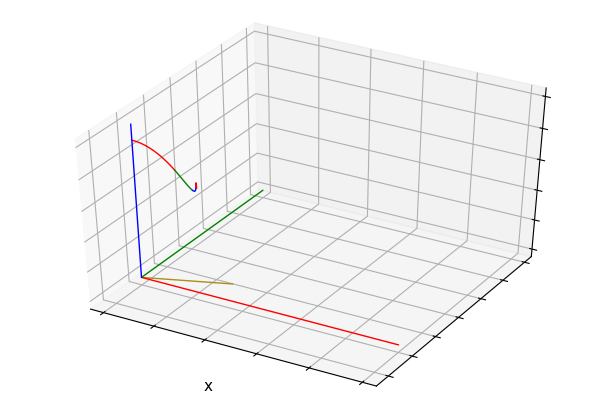

┌ Info: Saved animation to 
│   fn = /home/kuro/julia/Tutorial_julia/paper1/tmp.gif
└ @ Plots /home/kuro/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/kuro/julia/Tutorial_julia/paper1/tmp.gif")

In [53]:
pyplot(leg=false, ticks=nothing)
function test1(p)
    m , l0, s0, ctrl = p
    sol, foot_p, _ = cycleCalc(m, l0, s0, ctrl)
    if(size(sol)[1]<4)
        println("Param failed!")
        return
    end
    sol1, sol2, sol3, sol4 = sol
    x1, y1, z1 = [u[1] for u in sol1.u], [u[2] for u in sol1.u], [u[3] for u in sol1.u]
    x2, y2, z2 = [u[1] for u in sol2.u], [u[2] for u in sol2.u], [u[3] for u in sol2.u]
    x3, y3, z3 = [u[1] for u in sol3.u], [u[2] for u in sol3.u], [u[3] for u in sol3.u]
    x4, y4, z4 = [u[1] for u in sol4.u], [u[2] for u in sol4.u], [u[3] for u in sol4.u]
    p = plot3d(x1, y1, z1, color=[:red,])
    plot3d!(x2, y2, z2, color=[:green,])
    plot3d!(x3, y3, z3, color=[:blue,])
    plot3d!(x4, y4, z4, color=[:red,])
    plot3d!([0,foot_p[1]], [0,foot_p[2]], [0,foot_p[3]], seriestype=:scatter)
    plot3d!([0, 1], [0, 0], [0, 0], color=[:red,]);
    plot3d!([0, 0], [0, 1], [0, 0], color=[:green,]);
    plot3d!([0, 0], [0, 0], [0, 1], color=[:blue,]);
    xlabel!(p,"x");
    @gif for i in range(0, stop = 2π, length = 100)
        plot!(p, camera=(30*cos(i), 40)); # , aspect_ratio=:equal， 3D绘图好像不能设置这个
    end
end

# Test
p1 = (20, 0.8, [1.0, 1.0, 0.2], [pi/8, pi/9, 1e3, 1e3])
p2 = (20, 0.8, [0.9, 1.0, 0.0], [pi/18, pi/18, 1e4, 1e4])
test1(p2)

### 3.5 工具函数，计算仿真中间量

In [7]:
@everywhere function maxJointTorque(sol, p)
    if(size(sol)[1] >= 2)
        u = sol[2].u[end]
        p2 = p[2]
        return jointForce(u, p)
    else
        println("Error: no maxJointTorque!")
        return 0
    end
end

@everywhere function jointTorqueAcc_Raw(sol, p)
    if(size(sol)[1] < 4)
        println("failed in testing")
        return 0
    end
    
    Tacc = 0
    sol1, sol2, sol3, sol4 = sol
    p1, p2, p3, p4 = p
    torque_1 = jointForce(sol2.u[1], p)
    for i in 1:length(sol2.t)-1
        torque = jointForce(sol2.u[i+1], p)
        Tacc += (torque_1 + torque)*(sol2.t[i+1] - sol2.t[i])/2
        torque_1 = torque
    end
    torque_1 = jointForce(sol3.u[1], p)
    for i in 1:length(sol3.t)-1
        torque = jointForce(sol3.u[i+1], p)
        Tacc += (torque_1 + torque)*(sol3.t[i+1] - sol3.t[i])/2
        torque_1 = torque
    end
    return Tacc
end

@everywhere function jointTorqueAcc_Ex(sol, p)
    maxT = maxJointTorque(sol, p)
    c_n = jointTorqueAcc_Raw(sol, p)
    if maxT > 40
        return c_n*10 + maxT*0
    else
        return c_n*10 + maxT*0
    end
end

### 4. loss function design
在当前的设计下，参数主要是，初始条件（高度，速度），期望的终点条件（高度，速度），着地角度，以及两个k。需要考虑的性能主要包括：
1. 腿部的出力，出力应该映射到实际的关节设计上
2. 目标的达成情况，应该尽量达到期望的条件，但不强求
3. 插一个话题：可能这一个周期是能达到期望的条件，但以期望的条件为起点可能很难达到稳定的运行状态（问题）
4. 尽管失败的状态是不能达到期望的，我们还是应该在仿真阶段直接去掉这些样本

神经网络的设计应该是，输入<初始状态，期望状态>，输出一个控制参数，我们假定在优化中能够得到足够优秀的参数方案，也就是说在当前的条件下想要达到目标状态，这就已经是最佳方案了，因此我们可以直接用这些参数来进行设计，而我们同时也可以训练一个状态评价网络，这个网络用于制定目标状态；认为这种simplified结合神经网络以及传统算法将能够达到非常好的效果

考虑第一层的优化，优化的目标是首要稳定，其次接近目标状态，最后是出力优化，所谓的Multi-layer应该怎么处理？这里是一个非线性优化问题，并且需要构造一个[参数-->值]的函数

In [8]:
# 怎么确定惩罚的量级问题，以及怎么设计惩罚函数的问题
# h1 = -10:0.1:1;
# cost_seg1(x) = 1000 .*(1 .- exp.(x))
# y = cost_seg1(h1)
# index = findall(x->x<0, y)
# y[index] = zeros(length(index))
# plot(h1, y)
# cost1_func(x) = eff .*(1 .- exp.(x))
@everywhere eff = 8000
@everywhere function cost_func1(x)
    tmp = 1-exp(x)
    return tmp>0 ? eff*tmp : 0
end
@everywhere function evalSolution(sol, u0, target, p)
    # 1. fail
    cost1 = 0;
    if(size(sol)[1]==3)
        p1, p2, p3, p4 = p
        cost1 = cost_func1(sol[3].u[end][6])
    elseif(size(sol)[1]==2)
        p1, p2, p3 = p
        cost1 = cost_func1(sol[2].u[end][3]) + eff
    elseif(size(sol)[1]==1)
        p1, p2 = p
        cost1 = cost_func1(-compressingCalc(sol[1].u[end], p2)) + 2*eff
        # println(compressingCalc(sol[1].u[end], p2), "  ",cost_func1(compressingCalc(sol[1].u[end], p2)), "  ", 2*eff)
    elseif(size(sol)[1]==0)
        p1 = p[1]
        cost1 = cost_func1(calc_foot_end(u0, p1)[3]) + 3*eff
    else
        p1, p2, p3, p4 = p
        cost1 = 0.0
    end
    if(size(sol)[1]<4)
        return cost1+2000, 0, 0
    end
    # 2. target reached, distance cost
    sol1, sol2, sol3, sol4 = sol
    real_end = sol4.u[end][3:5]
    err = real_end - target
    cost2 = (abs(err[1])*4000 + abs(err[2])*2000 + abs(err[3])*2000)
    
    # 3. joint force cost
    
    cost3 = jointTorqueAcc_Ex(sol, p)
    
    # 4. 一些其他处理
    # cost2 = cost2>1000 ? 1000 : cost2
    # cost3 = cost3>1000 ? 1000 : cost3
    #cost2 = 1000 / (1+ exp(-cost2-10))
    #cost3 = 300 / (1 + exp(-cost3/10 - 10))
    
    return cost1, cost2, cost3
end
@everywhere function evalParam(m, l0, u0, target, ctrl)
    sol, foot_p, p = cycleCalc(m, l0, u0, ctrl)
    c1, c2, c3 = evalSolution(sol,u0, target, p)
    return c1+c2+c3
end

# Test
p_cycle = (20, 0.8, [0.9, 1.0, 0.0], [pi/18, pi/18, 1e4, 1e4])
m , l0, u0, ctrl = p_cycle
evalParam(m, l0, u0, u0, ctrl)

3184.796506514165

#### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>控制参数对应信息输出>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [9]:
# 解相关信息输出
function ctrlInfo(ctrl, u0, u1, ifplot)
    m, l0 = 20, 0.8
    sol, foot_p, p = cycleCalc(m, l0, u0, ctrl);
    println("完成阶段：",size(sol)[1], ", with ", ctrl)
    c1, c2, c3 = evalSolution(sol, u0, u0, p)
    println("三阶段loss：",[c1, c2, c3])
    println("最大关节扭矩：",maxJointTorque(sol, p))
    target = [1.0, 0.8, 0.2]
    reach = sol[end].u[end][3:5]
    println("目标：",target, ", 结果", reach)
    dis = target - reach
    dis = sqrt(dis[1]^2 + dis[2]^2 + dis[3]^2)
    println("距离：", dis)
    if ifplot
        cycle_p = (m, l0, u0, ctrl)
        test1(cycle_p)
    end
end
test_info(ctrl) = ctrlInfo(ctrl, [0.9, 1.0, 0.0], [1.0, 0.8, 0.2], false)

test_info (generic function with 1 method)

### 5. optimization based on GE or GA
说明：可以稳定求解但是效率太低了,但是发现在第二次运行的时候竟然快了很多，果然Julia的原因？相对于Ipopt是真的可以稳定求解一个足够优化的解，目前可行吧！嗯，很猥琐的办法!堆计算量，不过还是可以的！<br />
说明：
1. 如果不对关节扭矩做约束，还是能得到比较好的结果的，如果对关节力进行约束，看起来比较难
2. 调整GE的参数，一般都能收敛到同一个位置，所以可以认为这就是我们的优化函数给出的解
3. 实际发现通过地毯式搜索得到的解还GE算法得到的解，而地毯式的计算耗时要更长一点
4. 发现实际运行都是单核的，没有完全利用好遗传算法的多核计算优势
5. SLIP模型假设腿部是定刚度的，因此在弹出过程中，压缩大的过程会产生较大的力，压缩小的过程则出力更小，这种结果非常不符合实际情况，所以这里的最大扭矩才会很难降下来，但是，在本篇中我们先忽略这个！到下一篇论文中再讨论这个问题！本篇中主要讨论对应的思想！
6. 也就是说在这种情况下，我很难在最大出力与目标之间进行取舍，如果要限制最大出力，很大可能我们没办法达到目标状态，如果想要尽量接近目标状态，我们可能需要更大的出力，我们应该在效果的评价中找到一个足够好的平衡！也就是，去设计你的评价函数！

In [10]:
`默认认为这里GE参数范围给设定到0~10之间`
@everywhere function GEPara2Ctrl(pa, lim_u, lim_d)
    gap = lim_u - lim_d
    la = lim_u + lim_d
    return [(2*pa[1]-la)*pi/(3*gap), (2*pa[2]-la)*pi/(3*gap), pa[3]*2000, pa[4]*2000]
end
`fit function interface`
@everywhere function fitFuncCalc(vec)
    return evalParam(20, 0.8, [0.9, 1.0, 0.0], [1.0, 0.8, 0.2], GEPara2Ctrl(vec, 10.0, 0.0))
end
@everywhere function fitFuncCalc_EX(vec, u0, uend)
    return evalParam(20, 0.8, u0, uend, GEPara2Ctrl(vec, 10.0, 0.0))
end

`Variation function, x->v`
@everywhere function geneVariation(x, F)
    sz = size(x)
    v = zeros(sz)
    for i in 1:sz[1]
        r1 = rand(setdiff(1:sz[1], i))             # 随机选中一个不一样的index
        r2 = rand(setdiff(1:sz[1], [i, r1]))
        r3 = rand(setdiff(1:sz[1], [i, r1, r2]))
        v[i,:] = x[r1,:] + F*(x[r2,:] - x[r3,:])
    end
    return v
end

`cross function,writer may wrong`
@everywhere function geneCross(x, v, CR)
    `从x和v中选择出u`
    sz = size(x)
    r = rand(1:sz[2])
    u = zeros(sz)
    for i = 1:sz[2]
        cr = rand()
        if(cr<=CR || i==r)      # 随机选择其中的一维进行变化，其他的按概率变化
            u[:, i] = v[:, i]
        else
            u[:, i] = x[:, i]
        end
    end
    return u
end

`deal with bound`
@everywhere function dealBound!(u, Xs, Xx)
    for i in 1:size(u)[1]
        for j in 1:size(u)[2]
            u[i, j] = u[i, j]>Xs ? Xs : u[i, j]
            u[i, j] = u[i, j]<Xx ? Xx : u[i, j]
        end
    end
end
`select if new better`
function generateNew!(x, u)
    sz = size(u)
    obj1 = SharedArray{Float64}(sz[1])
    obj2 = SharedArray{Float64}(sz[1])
    @sync @distributed for i in 1:sz[1]
        # println(Threads.threadid())
        obj1[i] = fitFuncCalc(x[i, :])
        obj2[i] = fitFuncCalc(u[i, :])
    end
    for i in 1:sz[1]
        if obj2[i] < obj1[i]
            x[i, :] = u[i,:]
        end
    end
    minValue, minIdx = findmin(obj1)
    return minValue
end
`select if new better，run on sigle proc`
# 这里把粒度限制在单个求解上
# 需要注意的是这里的u和u0没有关系
@everywhere function generateNewSingle!(x, u, u0, ue)
    sz = size(u)
    obj1 = zeros(sz[1])
    for i in 1:sz[1]
        # println(Threads.threadid())
        obj1[i] = fitFuncCalc_EX(x[i, :], u0, ue)
        obj2 = fitFuncCalc_EX(u[i, :], u0, ue)
        if obj2 < obj1[i]
            x[i, :] = u[i,:]
        end
    end
    minValue, minIdx = findmin(obj1)
    return minValue
end

┌ Warning: special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = #shell_parse#353(::String, ::typeof(Base.shell_parse), ::String, ::Bool) at shell.jl:100
└ @ Base ./shell.jl:100


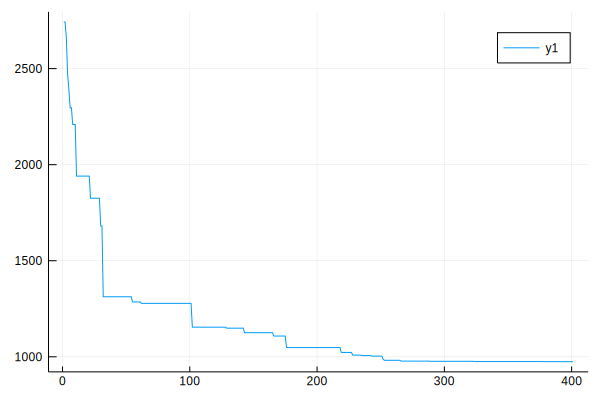

In [25]:

NP, D, G, CR, F, Xs, Xx = 30, 4, 400, 0.25, 0.6, 10, 0
x = rand(NP, D) .*(Xs-Xx) .+ Xx
trace = []
for gen in 1:G
    v = geneVariation(x, F)
    u = geneCross(x, v, CR)
    dealBound!(u, Xs, Xx)
    append!(trace, generateNew!(x, u))
end

# final answer
obj = []
for i in 1:size(x)[1]
    append!(obj, fitFuncCalc(x[i, :]))
end
minValue, minIdx = findmin(obj)
append!(trace, minValue)

plot(trace)

In [ ]:
# 单组测试输出
println("best Value:", minValue)
vec = x[minIdx, :]
ctrl = GEPara2Ctrl(vec, 10.0, 0.0);
println("best Ctrl:",ctrl)
test_info(ctrl)

### 计算生成gird文件

In [11]:
# 范围：h-[0.8, 1.1], vx-[-2, 2], vy-[-0.5, 0.5]
# 对单个<初始-终点>，优化计算参数
@everywhere function optOnePara(u0, uend)
    NP, D, G, CR, F, Xs, Xx = 30, 4, 400, 0.25, 0.6, 10, 0
    x = rand(NP, D) .*(Xs-Xx) .+ Xx
    trace = []
    for gen in 1:G
        v = geneVariation(x, F)
        u = geneCross(x, v, CR)
        dealBound!(u, Xs, Xx)
        append!(trace, generateNewSingle!(x, u, u0, uend))
    end

    # final answer
    obj = []
    for i in 1:size(x)[1]
        append!(obj, fitFuncCalc(x[i, :]))
    end
    minValue, minIdx = findmin(obj)
    
    vec = x[minIdx, :]
    ctrl = GEPara2Ctrl(vec, 10.0, 0.0);
    m, l0 = 20, 0.8
    sol, foot_p, p = cycleCalc(m, l0, u0, ctrl);
    mj = maxJointTorque(sol, p)
    
    target = uend
    reach = sol[end].u[end][3:5]
    dis = target - reach
    return ctrl, minValue, mj, dis
end
# test
# optOnePara([0.9, 1.0, 0.0], [1.0, 0.8, 0.2])

In [28]:
u0 = [0.8, -2.0, 0.5]
u1 = [0.8, 0.0, -0.5]
println(optOnePara(u0, u1))

([-0.5159311653075319, 0.20962340851919004, 20000.0, 8274.635382755912], 8306.455259901797, 120.95758497004795, [-8.085743115848754e-5, 6.069568251050781e-5, 0.00027640400670536636])


In [29]:
u0 = [0.8, -2.0, 0.5]
u1 = [0.8, 0.0, -0.5]
# ctrl = [-0.21783416707759523, 0.1366368390314248, 13840.87513196489, 20000.0]
ctrl = [-0.5159311653075319, 0.20962340851919004, 20000.0, 8274.635382755912]
ctrlInfo(ctrl, u0, u1, false)

完成阶段：4, with [-0.5159311653075319, 0.20962340851919004, 20000.0, 8274.635382755912]
三阶段loss：[0.0, 6000.754846373024, 143.92479239763512]
最大关节扭矩：120.95758497004795
目标：[1.0, 0.8, 0.2], 结果[0.8000808574311585, -6.069568251050781e-5, -0.5002764040067054]
距离：1.0818742174347284


    很显然在我不可能在其他的进程中操作在本进程中打开的文件，所以写文件应该只能由本进程进行操作，也就是必须要放在distributed之外

In [12]:
using ProgressMeter

In [ ]:
h = 0.8: 0.2 :1.1
vx = -2: 2 :2
vy = -0.5: 0.5 :0.5
res = SharedArray{Float64}(length(vx), length(vy), 15)
f = open("res.txt", "a")
prog = Progress(length(h)*length(h)*length(vx)*length(vy),1)
for u01 in h
    for u02 in vx
        for u03 in vy
            for ue1 in h
                @sync @distributed for i in 1:length(vx)
                    ue2 = vx[i]
                    for j in 1:length(vy)
                        ue3 = vy[j]
                        u0 = [u01, u02, u03]
                        uend = [ue1, ue2, ue3]
                        ctrl, minValue, mj, dis = [0.0, 0.0, 0.0, 0.0], 0.0, 0.0, [0.0, 0.0, 0.0]
                        try
                            ctrl, minValue, mj, dis = optOnePara(u0, uend)
                        catch
                            ctrl, minValue, mj, dis = [0.0, 0.0, 0.0, 0.0], 0.0, 0.0, [0.0, 0.0, 0.0]
                        end
                        res[i, j, :] = [u01, u02, u03, ue1, ue2, ue3, 
                                ctrl[1], ctrl[2], ctrl[3], ctrl[4], minValue, mj, 
                                dis[1], dis[2], dis[3]]
                    end
                end
                # 存储数据
                for i in 1:length(vx)
                    for j in 1:length(vy)
                        println(f, res[i, j, :])
                    end
                end
                next!(prog)
            end
        end
    end
end
println("file closed!")
close(f)

Progress:  72%|█████████████████████████████▋           |  ETA: 0:10:51┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:15

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase ~/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156


In [44]:
close(f)

### 6. 调试信息

In [13]:
h = 0.8: 0.2 :1.1   # 2
vx = -2: 2 :2       # 3
vy = -0.5: 0.5 :0.5 # 3
res = SharedArray{Float64}(length(vx), length(vy), 15)
prog = Progress(length(h)*length(h)*length(vx)*length(vy),1)

Progress(36, 1.0, 0, 1.571841437533149e9, 1.571841437533149e9, false, "Progress: ", 41, BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), :green, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x0000002b) open, 0 bytes waiting))), 0, 0)

In [31]:
36*0.72

25.919999999999998

In [32]:
i = 0
for u01 in h
    for u02 in vx
        for u03 in vy
            for ue1 in h
                i = i+1
                if i==27
                    println([u01, u02, u03, ue1])
                end
            end
        end
    end
end

[1.0, 0.0, 0.0, 0.8]


In [33]:
for i in 1:length(vx)
    ue2 = vx[i]
    for j in 1:length(vy)
        ue3 = vy[j]
        u0 = [1.0, 0.0, 0.0]
        uend = [0.8, ue2, ue3]
        println("uend here:", uend)
        ctrl, minValue, mj, dis = optOnePara(u0, uend)
    end
end

uend here:[0.8, -2.0, -0.5]
uend here:[0.8, -2.0, 0.0]
uend here:[0.8, -2.0, 0.5]
uend here:[0.8, 0.0, -0.5]
uend here:[0.8, 0.0, 0.0]


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/kuro/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/kuro/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/kuro/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/kuro/.julia/packages/DiffEqBase/8Qhx3/src/integrator_interface.jl:156


InterruptException: InterruptException:

In [ ]:
optOnePara([1.0, 0.0, 0.0], [0.8, 0.0, 0.0])